In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=4

In [3]:
print FOLD

4


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

In [9]:
#show_data(data,columns, 1,480, None)

In [10]:
#show_data2(data,columns)

# cv

In [11]:
n_reg_lookback=28

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [13]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                    ,
                   'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   

                   ])

In [15]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [20]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [21]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [24]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testlstm_l3_{}".format(FOLD), n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,model_type='conv',
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [25]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [26]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('l3_3003_conv_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 14.8043
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 5803 records out of 5803 records
no valid set
1538
0
26 32 (1, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1538/1538 [==============================] - 21s 14ms/step - loss: 0.2815 - total_loss: 0.2815 - reg_loss: 0.2815 - val_loss: 0.2508 - val_total_loss: 0.2508 - val_reg_loss: 0.2508
Epoch 2/100
1538/1538 [==============================] - 20s 13ms/step - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555 - val_loss:

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912465  0.016644  0.231260    7  2017-04-16
472     2.507290  2.531553 -0.024263  0.231913    1  2017-04-17
473     2.661330  2.673710 -0.012381  0.247765    2  2017-04-18
474     2.754815  2.755925 -0.001110  0.205983    3  2017-04-19
475     2.713762  2.711017  0.002745  0.235603    4  2017-04-20
476     2.999000  3.008416 -0.009416  0.153944    5  2017-04-21
477     3.075529  3.089501 -0.013972  0.185986    6  2017-04-22

0.213207739253
best_epochs [4, 5, 9, 2, 8]
(829, 1) 2.66168158992 

2
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 14.8043
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196718, 2) (48285, 2)
train/valid # (196718, 2) (48285, 2)
rand split across time
train has 196718 records out of 372221 records
valid has 48285 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1536
0
26 32 (2, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1536/1536 [==============================] - 20s 13ms/step - loss: 0.2960 - total_loss: 0.2960 - reg_loss: 0.2960 - val_loss: 0.2600 - val_total_loss: 0.2600 - val_reg_loss: 0.2600
Epoch 2/100
1536/1536 [==============================] - 20s 13ms/step 

y      pred     error    error2  day        date
dayidx                                                         
470     2.929110  2.935663 -0.006553  0.235163    6  2017-04-15
471     2.507290  2.531834 -0.024543  0.235306    7  2017-04-16
472     2.661330  2.674521 -0.013192  0.246305    1  2017-04-17
473     2.754815  2.781318 -0.026504  0.215456    2  2017-04-18
474     2.713762  2.736700 -0.022938  0.236852    3  2017-04-19
475     2.999000  3.008832 -0.009832  0.154437    4  2017-04-20
476     3.075529  3.075717 -0.000187  0.184467    5  2017-04-21

0.215426700792
best_epochs [4, 9, 7, 8, 5]
(829, 1) 2.51921280617 

3
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 14.8043
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196544, 2) (48244, 2)
train/valid # (196544, 2) (48244, 2)
rand split across time
train has 196544 records out of 372221 records
valid has 48244 records out of 372221 records
train has 7461 records out of 7461 records
no valid set
1535
0
26 32 (3, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1535/1535 [==============================] - 20s 13ms/step - loss: 0.2965 - total_loss: 0.2965 - reg_loss: 0.2965 - val_loss: 0.2631 - val_total_loss: 0.2631 - val_reg_loss: 0.2631
Epoch 2/100
1535/1535 [==============================] - 19s 13ms/step 

y      pred     error    error2  day        date
dayidx                                                         
469     2.929110  2.926210  0.002900  0.231469    5  2017-04-14
470     2.507290  2.533792 -0.026501  0.229596    6  2017-04-15
471     2.661330  2.664698 -0.003369  0.250769    7  2017-04-16
472     2.754815  2.754319  0.000496  0.209388    1  2017-04-17
473     2.713762  2.717381 -0.003619  0.236006    2  2017-04-18
474     2.999000  2.991767  0.007232  0.155639    3  2017-04-19
475     3.075529  3.083482 -0.007953  0.190306    4  2017-04-20

0.214738956303
best_epochs [5, 4, 7, 9, 8]
(829, 1) 2.61680646201 

4
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 14.8043
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196354, 2) (48204, 2)
train/valid # (196354, 2) (48204, 2)
rand split across time
train has 196354 records out of 372221 records
valid has 48204 records out of 372221 records
train has 8290 records out of 8290 records
no valid set
1534
0
26 32 (4, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1534/1534 [==============================] - 20s 13ms/step - loss: 0.2970 - total_loss: 0.2970 - reg_loss: 0.2970 - val_loss: 0.3282 - val_total_loss: 0.3282 - val_reg_loss: 0.3282
Epoch 2/100
1534/1534 [==============================] - 20s 13ms/step 

y      pred     error    error2  day        date
dayidx                                                         
468     2.929110  2.939020 -0.009910  0.237736    4  2017-04-13
469     2.507290  2.553212 -0.045922  0.235570    5  2017-04-14
470     2.661330  2.691155 -0.029825  0.258124    6  2017-04-15
471     2.754815  2.753305  0.001510  0.213424    7  2017-04-16
472     2.713762  2.739502 -0.025740  0.238094    1  2017-04-17
473     2.999000  3.004815 -0.005815  0.162230    2  2017-04-18
474     3.075529  3.099492 -0.023963  0.182914    3  2017-04-19

0.218298748299
best_epochs [3, 6, 8, 2, 4]
(829, 1) 2.7301012345 

5
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 14.8043
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196139, 2) (48148, 2)
train/valid # (196139, 2) (48148, 2)
rand split across time
train has 196139 records out of 372221 records
valid has 48148 records out of 372221 records
train has 9119 records out of 9119 records
no valid set
1532
0
26 32 (5, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1532/1532 [==============================] - 21s 14ms/step - loss: 0.2988 - total_loss: 0.2988 - reg_loss: 0.2988 - val_loss: 0.2716 - val_total_loss: 0.2716 - val_reg_loss: 0.2716
Epoch 2/100
1532/1532 [==============================] - 20s 13ms/step -

y      pred     error    error2  day        date
dayidx                                                         
467     2.929110  2.906261  0.022849  0.238818    3  2017-04-12
468     2.507290  2.518098 -0.010808  0.236612    4  2017-04-13
469     2.661330  2.647485  0.013845  0.260032    5  2017-04-14
470     2.754815  2.752334  0.002481  0.211200    6  2017-04-15
471     2.713762  2.727022 -0.013261  0.240861    7  2017-04-16
472     2.999000  3.002228 -0.003228  0.159936    1  2017-04-17
473     3.075529  3.093798 -0.018268  0.186514    2  2017-04-18

0.219139113852
best_epochs [4, 6, 5, 8, 7]
(829, 1) 2.71522260071 

6
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 15.1334
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (195924, 2) (48095, 2)
train/valid # (195924, 2) (48095, 2)
rand split across time
train has 195924 records out of 372221 records
valid has 48095 records out of 372221 records
train has 9948 records out of 9948 records
no valid set
1530
0
26 32 (6, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1530/1530 [==============================] - 21s 13ms/step - loss: 0.3006 - total_loss: 0.3006 - reg_loss: 0.3006 - val_loss: 0.2677 - val_total_loss: 0.2677 - val_reg_loss: 0.2677
Epoch 2/100
1530/1530 [==============================] - 20s 13ms/step 

y      pred     error    error2  day        date
dayidx                                                         
466     2.929110  2.913995  0.015115  0.239442    2  2017-04-11
467     2.507290  2.530796 -0.023505  0.241348    3  2017-04-12
468     2.661330  2.639938  0.021391  0.267060    4  2017-04-13
469     2.754815  2.749495  0.005320  0.217929    5  2017-04-14
470     2.713762  2.706476  0.007286  0.246926    6  2017-04-15
471     2.999000  2.976857  0.022143  0.163239    7  2017-04-16
472     3.075529  3.089823 -0.014294  0.186890    1  2017-04-17

0.223262186714
best_epochs [3, 5, 6, 4, 8]
(829, 1) 3.01316803195 

7
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 16.3101
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (195700, 2) (48038, 2)
train/valid # (195700, 2) (48038, 2)
rand split across time
train has 195700 records out of 372221 records
valid has 48038 records out of 372221 records
train has 10777 records out of 10777 records
no valid set
1528
0
26 32 (7, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1528/1528 [==============================] - 21s 13ms/step - loss: 0.3025 - total_loss: 0.3025 - reg_loss: 0.3025 - val_loss: 0.2971 - val_total_loss: 0.2971 - val_reg_loss: 0.2971
Epoch 2/100
1528/1528 [==============================] - 20s 13ms/ste

y      pred     error    error2  day        date
dayidx                                                         
465     2.929110  2.940179 -0.011070  0.233846    1  2017-04-10
466     2.507290  2.545199 -0.037908  0.248706    2  2017-04-11
467     2.661330  2.659003  0.002326  0.262799    3  2017-04-12
468     2.754815  2.759969 -0.005155  0.218887    4  2017-04-13
469     2.713762  2.739244 -0.025483  0.245391    5  2017-04-14
470     2.999000  2.992794  0.006206  0.158688    6  2017-04-15
471     3.075529  3.101813 -0.026284  0.187380    7  2017-04-16

0.222242315594
best_epochs [5, 6, 8, 4, 3]
(829, 1) 2.97727964786 

8
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 17.5743
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (195467, 2) (47976, 2)
train/valid # (195467, 2) (47976, 2)
rand split across time
train has 195467 records out of 372221 records
valid has 47976 records out of 372221 records
train has 11606 records out of 11606 records
no valid set
1527
0
26 32 (8, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1527/1527 [==============================] - 20s 13ms/step - loss: 0.3074 - total_loss: 0.3074 - reg_loss: 0.3074 - val_loss: 0.2829 - val_total_loss: 0.2829 - val_reg_loss: 0.2829
Epoch 2/100
1527/1527 [==============================] - 20s 13ms/ste

y      pred     error    error2  day        date
dayidx                                                         
464     2.929110  2.907899  0.021210  0.237314    7  2017-04-09
465     2.507290  2.538343 -0.031053  0.237780    1  2017-04-10
466     2.661330  2.620975  0.040355  0.268450    2  2017-04-11
467     2.754815  2.722755  0.032060  0.219759    3  2017-04-12
468     2.713762  2.729351 -0.015589  0.245423    4  2017-04-13
469     2.999000  2.963872  0.035127  0.164643    5  2017-04-14
470     3.075529  3.075135  0.000394  0.182554    6  2017-04-15

0.222274611329
best_epochs [7, 6, 4, 9, 8]
(829, 1) 2.72934221817 

9
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 18.8065
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (195242, 2) (47917, 2)
train/valid # (195242, 2) (47917, 2)
rand split across time
train has 195242 records out of 372221 records
valid has 47917 records out of 372221 records
train has 12435 records out of 12435 records
no valid set
1525
0
26 32 (9, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1525/1525 [==============================] - 20s 13ms/step - loss: 0.3137 - total_loss: 0.3137 - reg_loss: 0.3137 - val_loss: 0.2881 - val_total_loss: 0.2881 - val_reg_loss: 0.2881
Epoch 2/100
1525/1525 [==============================] - 20s 13ms/ste

y      pred     error    error2  day        date
dayidx                                                         
463     2.929110  2.915379  0.013731  0.252453    6  2017-04-08
464     2.507290  2.553895 -0.046605  0.245631    7  2017-04-09
465     2.661330  2.673278 -0.011948  0.270727    1  2017-04-10
466     2.754815  2.731988  0.022827  0.230076    2  2017-04-11
467     2.713762  2.715300 -0.001538  0.246374    3  2017-04-12
468     2.999000  2.962966  0.036034  0.168095    4  2017-04-13
469     3.075529  3.060464  0.015065  0.191325    5  2017-04-14

0.229240235121
best_epochs [3, 7, 5, 4, 6]
(829, 1) 2.5618403353 

10
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 19.9265
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (195075, 2) (47875, 2)
train/valid # (195075, 2) (47875, 2)
rand split across time
train has 195075 records out of 372221 records
valid has 47875 records out of 372221 records
train has 13264 records out of 13264 records
no valid set
1524
0
26 32 (10, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1524/1524 [==============================] - 20s 13ms/step - loss: 0.3116 - total_loss: 0.3116 - reg_loss: 0.3116 - val_loss: 0.3283 - val_total_loss: 0.3283 - val_reg_loss: 0.3283
Epoch 2/100
1524/1524 [==============================] - 19s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
462     2.929110  2.912614  0.016496  0.244699    5  2017-04-07
463     2.507290  2.525231 -0.017940  0.241340    6  2017-04-08
464     2.661330  2.682459 -0.021129  0.269442    7  2017-04-09
465     2.754815  2.742376  0.012439  0.224141    1  2017-04-10
466     2.713762  2.712081  0.001681  0.245960    2  2017-04-11
467     2.999000  2.979851  0.019149  0.170200    3  2017-04-12
468     3.075529  3.089175 -0.013645  0.188465    4  2017-04-13

0.226321132859
best_epochs [5, 4, 2, 7, 8]
(829, 1) 2.69078632267 

11
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 21.0577
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (194878, 2) (47832, 2)
train/valid # (194878, 2) (47832, 2)
rand split across time
train has 194878 records out of 372221 records
valid has 47832 records out of 372221 records
train has 14093 records out of 14093 records
no valid set
1522
0
26 32 (11, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1522/1522 [==============================] - 20s 13ms/step - loss: 0.3142 - total_loss: 0.3142 - reg_loss: 0.3142 - val_loss: 0.2781 - val_total_loss: 0.2781 - val_reg_loss: 0.2781
Epoch 2/100
1522/1522 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
461     2.929110  2.908072  0.021038  0.244085    4  2017-04-06
462     2.507290  2.536626 -0.029335  0.237158    5  2017-04-07
463     2.661330  2.681970 -0.020640  0.268182    6  2017-04-08
464     2.754815  2.725261  0.029554  0.220396    7  2017-04-09
465     2.713762  2.724599 -0.010837  0.241404    1  2017-04-10
466     2.999000  2.983755  0.015244  0.167674    2  2017-04-11
467     3.075529  3.078261 -0.002732  0.189333    3  2017-04-12

0.22403299276
best_epochs [6, 5, 8, 9, 3]
(829, 1) 3.01413621314 

12
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 22.1151
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (194664, 2) (47773, 2)
train/valid # (194664, 2) (47773, 2)
rand split across time
train has 194664 records out of 372221 records
valid has 47773 records out of 372221 records
train has 14922 records out of 14922 records
no valid set
1520
0
26 32 (12, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1520/1520 [==============================] - 20s 13ms/step - loss: 0.3097 - total_loss: 0.3097 - reg_loss: 0.3097 - val_loss: 0.2868 - val_total_loss: 0.2868 - val_reg_loss: 0.2868
Epoch 2/100
1520/1520 [==============================] - 19s 12ms/st

y      pred     error    error2  day        date
dayidx                                                         
460     2.929110  2.939247 -0.010137  0.252358    3  2017-04-05
461     2.507290  2.563556 -0.056266  0.242430    4  2017-04-06
462     2.661330  2.686130 -0.024800  0.272348    5  2017-04-07
463     2.754815  2.744218  0.010596  0.225869    6  2017-04-08
464     2.713762  2.739625 -0.025863  0.245821    7  2017-04-09
465     2.999000  3.009711 -0.010711  0.165782    1  2017-04-10
466     3.075529  3.077097 -0.001568  0.189401    2  2017-04-11

0.227715563302
best_epochs [7, 8, 5, 6, 9]
(829, 1) 2.95193113192 

13
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 23.1552
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (194446, 2) (47713, 2)
train/valid # (194446, 2) (47713, 2)
rand split across time
train has 194446 records out of 372221 records
valid has 47713 records out of 372221 records
train has 15751 records out of 15751 records
no valid set
1519
0
26 32 (13, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1519/1519 [==============================] - 19s 13ms/step - loss: 0.3161 - total_loss: 0.3161 - reg_loss: 0.3161 - val_loss: 0.2837 - val_total_loss: 0.2837 - val_reg_loss: 0.2837
Epoch 2/100
1519/1519 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
459     2.929110  2.901987  0.027123  0.256540    2  2017-04-04
460     2.507290  2.535708 -0.028417  0.244243    3  2017-04-05
461     2.661330  2.667984 -0.006654  0.270206    4  2017-04-06
462     2.754815  2.738971  0.015844  0.232283    5  2017-04-07
463     2.713762  2.720575 -0.006813  0.248545    6  2017-04-08
464     2.999000  2.933650  0.065350  0.169251    7  2017-04-09
465     3.075529  3.045506  0.030024  0.187233    1  2017-04-10

0.229757143876
best_epochs [4, 6, 8, 7, 3]
(829, 1) 3.02146322703 

14
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 24.2264
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (194239, 2) (47656, 2)
train/valid # (194239, 2) (47656, 2)
rand split across time
train has 194239 records out of 372221 records
valid has 47656 records out of 372221 records
train has 16580 records out of 16580 records
no valid set
1517
0
26 32 (14, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1517/1517 [==============================] - 20s 13ms/step - loss: 0.3154 - total_loss: 0.3154 - reg_loss: 0.3154 - val_loss: 0.2865 - val_total_loss: 0.2865 - val_reg_loss: 0.2865
Epoch 2/100
1517/1517 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
458     2.929110  2.928803  0.000307  0.244974    1  2017-04-03
459     2.507290  2.538230 -0.030939  0.242210    2  2017-04-04
460     2.661330  2.682413 -0.021083  0.265003    3  2017-04-05
461     2.754815  2.759551 -0.004737  0.227912    4  2017-04-06
462     2.713762  2.757081 -0.043320  0.246758    5  2017-04-07
463     2.999000  3.018448 -0.019448  0.160543    6  2017-04-08
464     3.075529  3.099786 -0.024257  0.190068    7  2017-04-09

0.225352714037
best_epochs [7, 5, 6, 9, 4]
(829, 1) 3.09379177571 

15
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 25.3577
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (194012, 2) (47596, 2)
train/valid # (194012, 2) (47596, 2)
rand split across time
train has 194012 records out of 372221 records
valid has 47596 records out of 372221 records
train has 17409 records out of 17409 records
no valid set
1515
0
26 32 (15, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1515/1515 [==============================] - 19s 13ms/step - loss: 0.3180 - total_loss: 0.3180 - reg_loss: 0.3180 - val_loss: 0.3079 - val_total_loss: 0.3079 - val_reg_loss: 0.3079
Epoch 2/100
1515/1515 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
457     2.929110  2.915160  0.013950  0.261001    7  2017-04-02
458     2.507290  2.560106 -0.052816  0.241694    1  2017-04-03
459     2.661330  2.683817 -0.022488  0.286191    2  2017-04-04
460     2.754815  2.720456  0.034358  0.230966    3  2017-04-05
461     2.713762  2.743081 -0.029319  0.255492    4  2017-04-06
462     2.999000  3.010202 -0.011203  0.167681    5  2017-04-07
463     3.075529  3.086927 -0.011397  0.192253    6  2017-04-08

0.233610916812
best_epochs [7, 5, 3, 4, 6]
(829, 1) 2.70904111885 

16
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 26.4659
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (193782, 2) (47536, 2)
train/valid # (193782, 2) (47536, 2)
rand split across time
train has 193782 records out of 372221 records
valid has 47536 records out of 372221 records
train has 18238 records out of 18238 records
no valid set
1513
0
26 32 (16, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1513/1513 [==============================] - 20s 13ms/step - loss: 0.3241 - total_loss: 0.3241 - reg_loss: 0.3241 - val_loss: 0.3035 - val_total_loss: 0.3035 - val_reg_loss: 0.3035
Epoch 2/100
1513/1513 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
456     2.929110  2.943249 -0.014139  0.270825    6  2017-04-01
457     2.507290  2.564503 -0.057212  0.251226    7  2017-04-02
458     2.661330  2.649015  0.012315  0.283360    1  2017-04-03
459     2.754815  2.723017  0.031798  0.236672    2  2017-04-04
460     2.713762  2.742941 -0.029180  0.258596    3  2017-04-05
461     2.999000  3.027817 -0.028817  0.174331    4  2017-04-06
462     3.075529  3.065852  0.009678  0.192537    5  2017-04-07

0.238221190398
best_epochs [3, 5, 6, 4, 2]
(829, 1) 2.58077027186 

17
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 27.6058
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (193614, 2) (47490, 2)
train/valid # (193614, 2) (47490, 2)
rand split across time
train has 193614 records out of 372221 records
valid has 47490 records out of 372221 records
train has 19067 records out of 19067 records
no valid set
1512
0
26 32 (17, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1512/1512 [==============================] - 20s 13ms/step - loss: 0.3204 - total_loss: 0.3204 - reg_loss: 0.3204 - val_loss: 0.2895 - val_total_loss: 0.2895 - val_reg_loss: 0.2895
Epoch 2/100
1512/1512 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
455     2.929110  2.937044 -0.007934  0.267821    5  2017-03-31
456     2.507290  2.543690 -0.036400  0.250117    6  2017-04-01
457     2.661330  2.655884  0.005445  0.281141    7  2017-04-02
458     2.754815  2.742985  0.011830  0.238805    1  2017-04-03
459     2.713762  2.750747 -0.036985  0.259398    2  2017-04-04
460     2.999000  2.994864  0.004136  0.174398    3  2017-04-05
461     3.075529  3.074695  0.000834  0.195641    4  2017-04-06

0.238188652941
best_epochs [3, 5, 4, 7, 6]
(829, 1) 2.65060620503 

18
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 28.7513
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (193421, 2) (47447, 2)
train/valid # (193421, 2) (47447, 2)
rand split across time
train has 193421 records out of 372221 records
valid has 47447 records out of 372221 records
train has 19896 records out of 19896 records
no valid set
1511
0
26 32 (18, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1511/1511 [==============================] - 20s 13ms/step - loss: 0.3192 - total_loss: 0.3192 - reg_loss: 0.3192 - val_loss: 0.2872 - val_total_loss: 0.2872 - val_reg_loss: 0.2872
Epoch 2/100
1511/1511 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
454     2.929110  2.925153  0.003957  0.270163    4  2017-03-30
455     2.507290  2.534716 -0.027425  0.256136    5  2017-03-31
456     2.661330  2.668221 -0.006891  0.287206    6  2017-04-01
457     2.754815  2.708449  0.046366  0.234542    7  2017-04-02
458     2.713762  2.707702  0.006060  0.259377    1  2017-04-03
459     2.999000  2.989205  0.009795  0.177574    2  2017-04-04
460     3.075529  3.063629  0.011900  0.194369    3  2017-04-05

0.239909681
best_epochs [4, 5, 3, 7, 1]
(829, 1) 2.75386217676 

19
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 29.7986
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (193210, 2) (47393, 2)
train/valid # (193210, 2) (47393, 2)
rand split across time
train has 193210 records out of 372221 records
valid has 47393 records out of 372221 records
train has 20725 records out of 20725 records
no valid set
1509
0
26 32 (19, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1509/1509 [==============================] - 19s 13ms/step - loss: 0.3226 - total_loss: 0.3226 - reg_loss: 0.3226 - val_loss: 0.3037 - val_total_loss: 0.3037 - val_reg_loss: 0.3037
Epoch 2/100
1509/1509 [==============================] - 19s 12ms/step

y      pred     error    error2  day        date
dayidx                                                         
453     2.929110  2.948761 -0.019651  0.270958    3  2017-03-29
454     2.507290  2.557194 -0.049904  0.253938    4  2017-03-30
455     2.661330  2.663851 -0.002521  0.283328    5  2017-03-31
456     2.754815  2.757356 -0.002541  0.238491    6  2017-04-01
457     2.713762  2.726044 -0.012282  0.254341    7  2017-04-02
458     2.999000  2.979238  0.019762  0.180463    1  2017-04-03
459     3.075529  3.064391  0.011138  0.197185    2  2017-04-04

0.239814814788
best_epochs [6, 3, 4, 2, 9]
(829, 1) 2.73176716611 

20
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 30.7963
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (193000, 2) (47336, 2)
train/valid # (193000, 2) (47336, 2)
rand split across time
train has 193000 records out of 372221 records
valid has 47336 records out of 372221 records
train has 21554 records out of 21554 records
no valid set
1507
0
26 32 (20, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1507/1507 [==============================] - 20s 13ms/step - loss: 0.3267 - total_loss: 0.3267 - reg_loss: 0.3267 - val_loss: 0.2981 - val_total_loss: 0.2981 - val_reg_loss: 0.2981
Epoch 2/100
1507/1507 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
452     2.929110  2.956270 -0.027161  0.259755    2  2017-03-28
453     2.507290  2.564057 -0.056767  0.250359    3  2017-03-29
454     2.661330  2.672976 -0.011646  0.277407    4  2017-03-30
455     2.754815  2.784710 -0.029896  0.238704    5  2017-03-31
456     2.713762  2.758942 -0.045180  0.264627    6  2017-04-01
457     2.999000  3.001580 -0.002580  0.171376    7  2017-04-02
458     3.075529  3.098213 -0.022684  0.188267    1  2017-04-03

0.235785025327
best_epochs [6, 8, 5, 7, 2]
(829, 1) 2.99808814635 

21
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 31.7929
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (192787, 2) (47281, 2)
train/valid # (192787, 2) (47281, 2)
rand split across time
train has 192787 records out of 372221 records
valid has 47281 records out of 372221 records
train has 22383 records out of 22383 records
no valid set
1506
0
26 32 (21, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1506/1506 [==============================] - 20s 13ms/step - loss: 0.3284 - total_loss: 0.3284 - reg_loss: 0.3284 - val_loss: 0.2950 - val_total_loss: 0.2950 - val_reg_loss: 0.2950
Epoch 2/100
1506/1506 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
451     2.929110  2.901636  0.027474  0.274626    1  2017-03-27
452     2.507290  2.516976 -0.009686  0.254056    2  2017-03-28
453     2.661330  2.649087  0.012243  0.283058    3  2017-03-29
454     2.754815  2.700231  0.054584  0.240631    4  2017-03-30
455     2.713762  2.699091  0.014670  0.263281    5  2017-03-31
456     2.999000  2.958586  0.040413  0.185407    6  2017-04-01
457     3.075529  3.071108  0.004421  0.199493    7  2017-04-02

0.242935892749
best_epochs [6, 2, 5, 4, 7]
(829, 1) 3.03012363602 

22
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 32.871
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (192558, 2) (47221, 2)
train/valid # (192558, 2) (47221, 2)
rand split across time
train has 192558 records out of 372221 records
valid has 47221 records out of 372221 records
train has 23212 records out of 23212 records
no valid set
1504
0
26 32 (22, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1504/1504 [==============================] - 20s 13ms/step - loss: 0.3277 - total_loss: 0.3277 - reg_loss: 0.3277 - val_loss: 0.2991 - val_total_loss: 0.2991 - val_reg_loss: 0.2991
Epoch 2/100
1504/1504 [==============================] - 19s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
450     2.929110  2.936246 -0.007136  0.261135    7  2017-03-26
451     2.507290  2.532486 -0.025195  0.255695    1  2017-03-27
452     2.661330  2.677383 -0.016053  0.282955    2  2017-03-28
453     2.754815  2.744195  0.010620  0.240779    3  2017-03-29
454     2.713762  2.740678 -0.026916  0.262285    4  2017-03-30
455     2.999000  2.972973  0.026027  0.185030    5  2017-03-31
456     3.075529  3.087223 -0.011694  0.198344    6  2017-04-01

0.240889063378
best_epochs [2, 7, 6, 3, 4]
(829, 1) 2.74465911478 

23
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 33.9745
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (192329, 2) (47160, 2)
train/valid # (192329, 2) (47160, 2)
rand split across time
train has 192329 records out of 372221 records
valid has 47160 records out of 372221 records
train has 24041 records out of 24041 records
no valid set
1502
0
26 32 (23, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1502/1502 [==============================] - 20s 13ms/step - loss: 0.3361 - total_loss: 0.3361 - reg_loss: 0.3361 - val_loss: 0.3325 - val_total_loss: 0.3325 - val_reg_loss: 0.3325
Epoch 2/100
1502/1502 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
449     2.929110  2.910865  0.018245  0.268744    6  2017-03-25
450     2.507290  2.512031 -0.004741  0.250524    7  2017-03-26
451     2.661330  2.644658  0.016672  0.274235    1  2017-03-27
452     2.754815  2.746993  0.007822  0.241529    2  2017-03-28
453     2.713762  2.697386  0.016376  0.265768    3  2017-03-29
454     2.999000  2.962963  0.036037  0.184118    4  2017-03-30
455     3.075529  3.057781  0.017748  0.195075    5  2017-03-31

0.239999173507
best_epochs [5, 3, 4, 7, 6]
(829, 1) 2.44879215976 

24
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 35.2084
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (192162, 2) (47113, 2)
train/valid # (192162, 2) (47113, 2)
rand split across time
train has 192162 records out of 372221 records
valid has 47113 records out of 372221 records
train has 24870 records out of 24870 records
no valid set
1501
0
26 32 (24, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1501/1501 [==============================] - 20s 13ms/step - loss: 0.3289 - total_loss: 0.3289 - reg_loss: 0.3289 - val_loss: 0.2994 - val_total_loss: 0.2994 - val_reg_loss: 0.2994
Epoch 2/100
1501/1501 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
448     2.929110  2.928368  0.000742  0.267491    5  2017-03-24
449     2.507290  2.522107 -0.014817  0.254777    6  2017-03-25
450     2.661330  2.691634 -0.030304  0.279480    7  2017-03-26
451     2.754815  2.760415 -0.005600  0.239401    1  2017-03-27
452     2.713762  2.734873 -0.021111  0.268928    2  2017-03-28
453     2.999000  2.989525  0.009475  0.182607    3  2017-03-29
454     3.075529  3.064112  0.011417  0.194983    4  2017-03-30

0.241095209316
best_epochs [3, 4, 5, 6, 8]
(829, 1) 2.58444647295 

25
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 36.3351
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (191976, 2) (47072, 2)
train/valid # (191976, 2) (47072, 2)
rand split across time
train has 191976 records out of 372221 records
valid has 47072 records out of 372221 records
train has 25699 records out of 25699 records
no valid set
1499
0
26 32 (25, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1499/1499 [==============================] - 20s 13ms/step - loss: 0.3309 - total_loss: 0.3309 - reg_loss: 0.3309 - val_loss: 0.2950 - val_total_loss: 0.2950 - val_reg_loss: 0.2950
Epoch 2/100
1499/1499 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
447     2.929110  2.918366  0.010744  0.269754    4  2017-03-23
448     2.507290  2.524689 -0.017399  0.254727    5  2017-03-24
449     2.661330  2.675849 -0.014520  0.282794    6  2017-03-25
450     2.754815  2.714772  0.040042  0.244519    7  2017-03-26
451     2.713762  2.697547  0.016214  0.264231    1  2017-03-27
452     2.999000  2.962138  0.036861  0.178598    2  2017-03-28
453     3.075529  3.051190  0.024339  0.197152    3  2017-03-29

0.241682226763
best_epochs [4, 5, 3, 1, 8]
(829, 1) 2.66574599963 

26
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 37.3741
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (191768, 2) (47016, 2)
train/valid # (191768, 2) (47016, 2)
rand split across time
train has 191768 records out of 372221 records
valid has 47016 records out of 372221 records
train has 26528 records out of 26528 records
no valid set
1498
0
26 32 (26, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1498/1498 [==============================] - 20s 13ms/step - loss: 0.3328 - total_loss: 0.3328 - reg_loss: 0.3328 - val_loss: 0.3074 - val_total_loss: 0.3074 - val_reg_loss: 0.3074
Epoch 2/100
1498/1498 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
446     2.929110  2.952478 -0.023368  0.275165    3  2017-03-22
447     2.507290  2.549363 -0.042072  0.260019    4  2017-03-23
448     2.661330  2.685137 -0.023808  0.282529    5  2017-03-24
449     2.754815  2.771463 -0.016648  0.241394    6  2017-03-25
450     2.713762  2.773642 -0.059880  0.264525    7  2017-03-26
451     2.999000  2.994533  0.004467  0.179563    1  2017-03-27
452     3.075529  3.097019 -0.021489  0.199290    2  2017-03-28

0.243212028228
best_epochs [3, 5, 4, 2, 7]
(829, 1) 2.76780329151 

27
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 38.4506
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (191553, 2) (46958, 2)
train/valid # (191553, 2) (46958, 2)
rand split across time
train has 191553 records out of 372221 records
valid has 46958 records out of 372221 records
train has 27357 records out of 27357 records
no valid set
1496
0
26 32 (27, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1496/1496 [==============================] - 19s 13ms/step - loss: 0.3393 - total_loss: 0.3393 - reg_loss: 0.3393 - val_loss: 0.3029 - val_total_loss: 0.3029 - val_reg_loss: 0.3029
Epoch 2/100
1496/1496 [==============================] - 19s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
445     2.929110  2.894327  0.034783  0.273450    2  2017-03-21
446     2.507290  2.522429 -0.015138  0.256525    3  2017-03-22
447     2.661330  2.658983  0.002347  0.277835    4  2017-03-23
448     2.754815  2.736028  0.018787  0.241233    5  2017-03-24
449     2.713762  2.709475  0.004286  0.266556    6  2017-03-25
450     2.999000  2.954477  0.044523  0.183070    7  2017-03-26
451     3.075529  3.062624  0.012905  0.196053    1  2017-03-27

0.242102955177
best_epochs [4, 3, 8, 7, 6]
(829, 1) 2.98434376524 

28
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 39.4798
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (191331, 2) (46900, 2)
train/valid # (191331, 2) (46900, 2)
rand split across time
train has 191331 records out of 372221 records
valid has 46900 records out of 372221 records
train has 28186 records out of 28186 records
no valid set
1494
0
26 32 (28, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1494/1494 [==============================] - 19s 13ms/step - loss: 0.3388 - total_loss: 0.3388 - reg_loss: 0.3388 - val_loss: 0.3298 - val_total_loss: 0.3298 - val_reg_loss: 0.3298
Epoch 2/100
1494/1494 [==============================] - 19s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
444     2.929110  2.925229  0.003881  0.271950    1  2017-03-20
445     2.507290  2.535106 -0.027816  0.255146    2  2017-03-21
446     2.661330  2.678217 -0.016887  0.275907    3  2017-03-22
447     2.754815  2.733559  0.021256  0.245879    4  2017-03-23
448     2.713762  2.705530  0.008232  0.265743    5  2017-03-24
449     2.999000  2.989123  0.009876  0.180214    6  2017-03-25
450     3.075529  3.072270  0.003260  0.192090    7  2017-03-26

0.240989791214
best_epochs [3, 6, 7, 8, 5]
(829, 1) 3.10777807306 

29
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 40.7934
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (191098, 2) (46838, 2)
train/valid # (191098, 2) (46838, 2)
rand split across time
train has 191098 records out of 372221 records
valid has 46838 records out of 372221 records
train has 29015 records out of 29015 records
no valid set
1492
0
26 32 (29, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1489/1492 [============================>.] - ETA: 0s - loss: 8.4603 - total_loss: 8.4603 - reg_loss: 8.4603Epoch 00001: saving model to testlstm_l3_4/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1492/1492 [=========================

y      pred     error    error2  day        date
dayidx                                                         
443     2.929110  2.915428  0.013682  0.268384    7  2017-03-19
444     2.507290  2.542910 -0.035620  0.256281    1  2017-03-20
445     2.661330  2.665422 -0.004092  0.285585    2  2017-03-21
446     2.754815  2.766530 -0.011716  0.249775    3  2017-03-22
447     2.713762  2.722378 -0.008617  0.270790    4  2017-03-23
448     2.999000  2.997610  0.001390  0.184193    5  2017-03-24
449     3.075529  3.107550 -0.032021  0.205143    6  2017-03-25

0.245735946426
best_epochs [2, 4, 5, 3, 7]
(829, 1) 2.77867526942 

30
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 41.9859
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (190869, 2) (46776, 2)
train/valid # (190869, 2) (46776, 2)
rand split across time
train has 190869 records out of 372221 records
valid has 46776 records out of 372221 records
train has 29844 records out of 29844 records
no valid set
1491
0
26 32 (30, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1491/1491 [==============================] - 19s 13ms/step - loss: 0.3427 - total_loss: 0.3427 - reg_loss: 0.3427 - val_loss: 0.3130 - val_total_loss: 0.3130 - val_reg_loss: 0.3130
Epoch 2/100
1491/1491 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
442     2.929110  2.849260  0.079850  0.271698    6  2017-03-18
443     2.507290  2.491290  0.016000  0.248006    7  2017-03-19
444     2.661330  2.641911  0.019419  0.282731    1  2017-03-20
445     2.754815  2.719322  0.035492  0.244024    2  2017-03-21
446     2.713762  2.718500 -0.004739  0.258658    3  2017-03-22
447     2.999000  2.987076  0.011924  0.179262    4  2017-03-23
448     3.075529  3.071753  0.003777  0.195034    5  2017-03-24

0.239916317894
best_epochs [7, 5, 4, 8, 6]
(829, 1) 2.47220638527 

31
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 43.2281
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (190689, 2) (46728, 2)
train/valid # (190689, 2) (46728, 2)
rand split across time
train has 190689 records out of 372221 records
valid has 46728 records out of 372221 records
train has 30673 records out of 30673 records
no valid set
1489
0
26 32 (31, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1487/1489 [============================>.] - ETA: 0s - loss: 1.5235 - total_loss: 1.5235 - reg_loss: 1.5235Epoch 00001: saving model to testlstm_l3_4/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1489/1489 [=========================

y      pred     error    error2  day        date
dayidx                                                         
441     2.929110  2.934540 -0.005430  0.272526    5  2017-03-17
442     2.507290  2.551141 -0.043851  0.259804    6  2017-03-18
443     2.661330  2.640406  0.020924  0.291520    7  2017-03-19
444     2.754815  2.730294  0.024521  0.241482    1  2017-03-20
445     2.713762  2.718609 -0.004847  0.267605    2  2017-03-21
446     2.999000  2.973273  0.025727  0.180469    3  2017-03-22
447     3.075529  3.075129  0.000400  0.199889    4  2017-03-23

0.244756527411
best_epochs [4, 7, 6, 5, 3]
(829, 1) 2.66604256022 

32
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 44.4464
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (190499, 2) (46685, 2)
train/valid # (190499, 2) (46685, 2)
rand split across time
train has 190499 records out of 372221 records
valid has 46685 records out of 372221 records
train has 31502 records out of 31502 records
no valid set
1488
0
26 32 (32, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1488/1488 [==============================] - 20s 13ms/step - loss: 0.3389 - total_loss: 0.3389 - reg_loss: 0.3389 - val_loss: 0.3311 - val_total_loss: 0.3311 - val_reg_loss: 0.3311
Epoch 2/100
1488/1488 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
440     2.929110  2.914873  0.014237  0.271581    4  2017-03-16
441     2.507290  2.517332 -0.010042  0.254978    5  2017-03-17
442     2.661330  2.647096  0.014234  0.288053    6  2017-03-18
443     2.754815  2.716153  0.038662  0.247535    7  2017-03-19
444     2.713762  2.692775  0.020987  0.264088    1  2017-03-20
445     2.999000  2.966818  0.032182  0.182263    2  2017-03-21
446     3.075529  3.041938  0.033592  0.199814    3  2017-03-22

0.244044470548
best_epochs [5, 3, 7, 6, 4]
(829, 1) 2.73842170904 

33
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 45.5115
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (190289, 2) (46628, 2)
train/valid # (190289, 2) (46628, 2)
rand split across time
train has 190289 records out of 372221 records
valid has 46628 records out of 372221 records
train has 32331 records out of 32331 records
no valid set
1486
0
26 32 (33, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1486/1486 [==============================] - 20s 13ms/step - loss: 0.3395 - total_loss: 0.3395 - reg_loss: 0.3395 - val_loss: 0.3158 - val_total_loss: 0.3158 - val_reg_loss: 0.3158
Epoch 2/100
1486/1486 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
439     2.929110  2.914902  0.014208  0.273325    3  2017-03-15
440     2.507290  2.524830 -0.017540  0.259729    4  2017-03-16
441     2.661330  2.639193  0.022137  0.280961    5  2017-03-17
442     2.754815  2.721380  0.033435  0.240639    6  2017-03-18
443     2.713762  2.687278  0.026484  0.261956    7  2017-03-19
444     2.999000  2.978178  0.020822  0.182483    1  2017-03-20
445     3.075529  3.086686 -0.011157  0.198993    2  2017-03-21

0.242583843218
best_epochs [3, 2, 7, 5, 6]
(829, 1) 2.7062699082 

34
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 46.5688
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (190070, 2) (46571, 2)
train/valid # (190070, 2) (46571, 2)
rand split across time
train has 190070 records out of 372221 records
valid has 46571 records out of 372221 records
train has 33160 records out of 33160 records
no valid set
1484
0
26 32 (34, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1484/1484 [==============================] - 20s 13ms/step - loss: 0.3415 - total_loss: 0.3415 - reg_loss: 0.3415 - val_loss: 0.3103 - val_total_loss: 0.3103 - val_reg_loss: 0.3103
Epoch 2/100
1484/1484 [==============================] - 19s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
438     2.929110  2.926263  0.002847  0.271097    2  2017-03-14
439     2.507290  2.538518 -0.031228  0.257621    3  2017-03-15
440     2.661330  2.678686 -0.017356  0.290040    4  2017-03-16
441     2.754815  2.758139 -0.003324  0.244790    5  2017-03-17
442     2.713762  2.721028 -0.007266  0.261352    6  2017-03-18
443     2.999000  2.986255  0.012745  0.183457    7  2017-03-19
444     3.075529  3.083849 -0.008320  0.205128    1  2017-03-20

0.244783770388
best_epochs [5, 4, 2, 1, 7]
(829, 1) 3.00515434423 

35
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 47.4733
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (189848, 2) (46515, 2)
train/valid # (189848, 2) (46515, 2)
rand split across time
train has 189848 records out of 372221 records
valid has 46515 records out of 372221 records
train has 33989 records out of 33989 records
no valid set
1483
0
26 32 (35, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1483/1483 [==============================] - 20s 13ms/step - loss: 0.3442 - total_loss: 0.3442 - reg_loss: 0.3442 - val_loss: 0.3239 - val_total_loss: 0.3239 - val_reg_loss: 0.3239
Epoch 2/100
1483/1483 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
437     2.929110  2.889921  0.039189  0.263550    1  2017-03-13
438     2.507290  2.509604 -0.002313  0.255723    2  2017-03-14
439     2.661330  2.684238 -0.022908  0.279241    3  2017-03-15
440     2.754815  2.782093 -0.027278  0.246394    4  2017-03-16
441     2.713762  2.719941 -0.006179  0.261728    5  2017-03-17
442     2.999000  2.987913  0.011087  0.178874    6  2017-03-18
443     3.075529  3.081337 -0.005807  0.200256    7  2017-03-19

0.240823474482
best_epochs [6, 5, 3, 2, 7]
(829, 1) 3.09337778932 

36
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 48.7491
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (189615, 2) (46453, 2)
train/valid # (189615, 2) (46453, 2)
rand split across time
train has 189615 records out of 372221 records
valid has 46453 records out of 372221 records
train has 34818 records out of 34818 records
no valid set
1481
0
26 32 (36, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1481/1481 [==============================] - 19s 13ms/step - loss: 0.3491 - total_loss: 0.3491 - reg_loss: 0.3491 - val_loss: 0.3180 - val_total_loss: 0.3180 - val_reg_loss: 0.3180
Epoch 2/100
1481/1481 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
436     2.929110  2.913844  0.015266  0.272780    7  2017-03-12
437     2.507290  2.516812 -0.009521  0.261746    1  2017-03-13
438     2.661330  2.658753  0.002576  0.281689    2  2017-03-14
439     2.754815  2.797750 -0.042935  0.246340    3  2017-03-15
440     2.713762  2.741682 -0.027920  0.273584    4  2017-03-16
441     2.999000  2.964068  0.034932  0.182495    5  2017-03-17
442     3.075529  3.101599 -0.026069  0.212509    6  2017-03-18

0.247306266424
best_epochs [4, 3, 7, 6, 8]
(829, 1) 2.80117658313 

37
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 49.8797
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (189388, 2) (46393, 2)
train/valid # (189388, 2) (46393, 2)
rand split across time
train has 189388 records out of 372221 records
valid has 46393 records out of 372221 records
train has 35647 records out of 35647 records
no valid set
1479
0
26 32 (37, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1479/1479 [==============================] - 19s 13ms/step - loss: 0.3508 - total_loss: 0.3508 - reg_loss: 0.3508 - val_loss: 0.3158 - val_total_loss: 0.3158 - val_reg_loss: 0.3158
Epoch 2/100
1479/1479 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
435     2.929110  2.911057  0.018053  0.278325    6  2017-03-11
436     2.507290  2.526106 -0.018815  0.258286    7  2017-03-12
437     2.661330  2.645579  0.015751  0.283007    1  2017-03-13
438     2.754815  2.723798  0.031017  0.251654    2  2017-03-14
439     2.713762  2.695124  0.018638  0.267109    3  2017-03-15
440     2.999000  2.961048  0.037952  0.186364    4  2017-03-16
441     3.075529  3.093445 -0.017916  0.209082    5  2017-03-17

0.247689624149
best_epochs [5, 4, 6, 3, 8]
(829, 1) 2.56862354034 

38
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 51.0865
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (189213, 2) (46349, 2)
train/valid # (189213, 2) (46349, 2)
rand split across time
train has 189213 records out of 372221 records
valid has 46349 records out of 372221 records
train has 36476 records out of 36476 records
no valid set
1478
0
26 32 (38, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1478/1478 [==============================] - 19s 13ms/step - loss: 0.3484 - total_loss: 0.3484 - reg_loss: 0.3484 - val_loss: 0.3221 - val_total_loss: 0.3221 - val_reg_loss: 0.3221
Epoch 2/100
1478/1478 [==============================] - 18s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
434     2.929110  2.911900  0.017210  0.281559    5  2017-03-10
435     2.507290  2.499213  0.008078  0.256467    6  2017-03-11
436     2.661330  2.645634  0.015696  0.288145    7  2017-03-12
437     2.754815  2.741831  0.012984  0.249116    1  2017-03-13
438     2.713762  2.708925  0.004837  0.263848    2  2017-03-14
439     2.999000  2.953536  0.045464  0.182489    3  2017-03-15
440     3.075529  3.048858  0.026672  0.206288    4  2017-03-16

0.246844467343
best_epochs [7, 4, 5, 8, 3]
(829, 1) 2.68385088107 

39
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 52.0488
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (189027, 2) (46304, 2)
train/valid # (189027, 2) (46304, 2)
rand split across time
train has 189027 records out of 372221 records
valid has 46304 records out of 372221 records
train has 37305 records out of 37305 records
no valid set
1476
0
26 32 (39, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1476/1476 [==============================] - 18s 12ms/step - loss: 0.3478 - total_loss: 0.3478 - reg_loss: 0.3478 - val_loss: 0.3174 - val_total_loss: 0.3174 - val_reg_loss: 0.3174
Epoch 2/100
1476/1476 [==============================] - 17s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
433     2.929110  2.938495 -0.009385  0.282749    4  2017-03-09
434     2.507290  2.547412 -0.040121  0.257421    5  2017-03-10
435     2.661330  2.674733 -0.013403  0.284709    6  2017-03-11
436     2.754815  2.773249 -0.018434  0.251927    7  2017-03-12
437     2.713762  2.724582 -0.010820  0.271068    1  2017-03-13
438     2.999000  2.972476  0.026523  0.186556    2  2017-03-14
439     3.075529  3.054840  0.020689  0.208253    3  2017-03-15

0.2489547121
best_epochs [4, 6, 5, 1, 3]
(829, 1) 2.81447339891


In [27]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

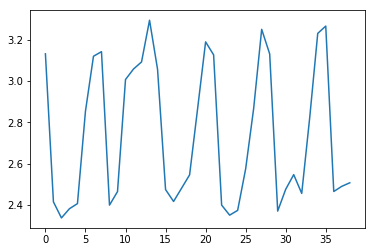

In [28]:
plt.plot(testpreds[129])

In [29]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [30]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.825737   
air_0164b9927d20bcc3_2017-04-23              1.445929   
air_0241aa3964b7f861_2017-04-23              2.329264   
air_0328696196e46f18_2017-04-23              2.175944   
air_034a3d5b40d5b1b1_2017-04-23              3.533065   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.207368  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.245795  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.270376  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.810499  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  33.228712

In [31]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [32]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [33]:
submission.to_csv("../submission/l3_3003_conv_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')